In [ ]:
# Install the required libraries.
!pip install pafy youtube-dl moviepy
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Flatten
from tensorflow.keras.layers import Dropout



In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
# Step 1: Download the UCF50 dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar -O UCF50.rar

# Step 2: Install unrar if not already installed
!apt-get install unrar -y

# Step 3: Create a directory to extract the dataset
!mkdir -p UCF50_dataset

# Step 4: Extract the .rar file
!unrar x -y UCF50.rar UCF50_dataset/

# Step 5: Verify the extracted directory
!ls UCF50_dataset/UCF50/

--2025-06-25 17:52:51--  https://www.crcv.ucf.edu/data/UCF50.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3233554570 (3.0G) [application/x-rar-compressed]
Saving to: ‘UCF50.rar’

UCF50.rar             9%[>                   ] 302.26M  27.4MB/s    eta 1m 52s ^C
^C

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from UCF50.rar

Extracting  UCF50_dataset/UCF50/BaseballPitch/v_BaseballPitch_g01_c01.avi       0%  OK 
Extracting  UCF50_dataset/UCF50/BaseballPitch/v_BaseballPitch_g01_c02.avi       0%  OK 
Extracting  UCF50_dataset/UCF50/BaseballPitch/v_BaseballPitch_g01_c03.avi       0%  OK 
Extracting  UCF50_dataset/UCF50/BaseballPitch/v_BaseballPitch_g01_c04.avi       0%  OK 
Extracting  UCF50_dataset/UCF5

In [ ]:
!ls UCF50_dataset/UCF50/

BaseballPitch  HorseRiding     PlayingPiano	   Skiing
Basketball     HulaHoop        PlayingTabla	   Skijet
BenchPress     JavelinThrow    PlayingViolin	   SoccerJuggling
Biking	       JugglingBalls   PoleVault	   Swing
Billiards      JumpingJack     PommelHorse	   TaiChi
BreastStroke   JumpRope        PullUps		   TennisSwing
CleanAndJerk   Kayaking        Punch		   ThrowDiscus
Diving	       Lunges	       PushUps		   TrampolineJumping
Drumming       MilitaryParade  RockClimbingIndoor  VolleyballSpiking
Fencing        Mixing	       RopeClimbing	   WalkingWithDog
GolfSwing      Nunchucks       Rowing		   YoYo
HighJump       PizzaTossing    SalsaSpin
HorseRace      PlayingGuitar   SkateBoarding


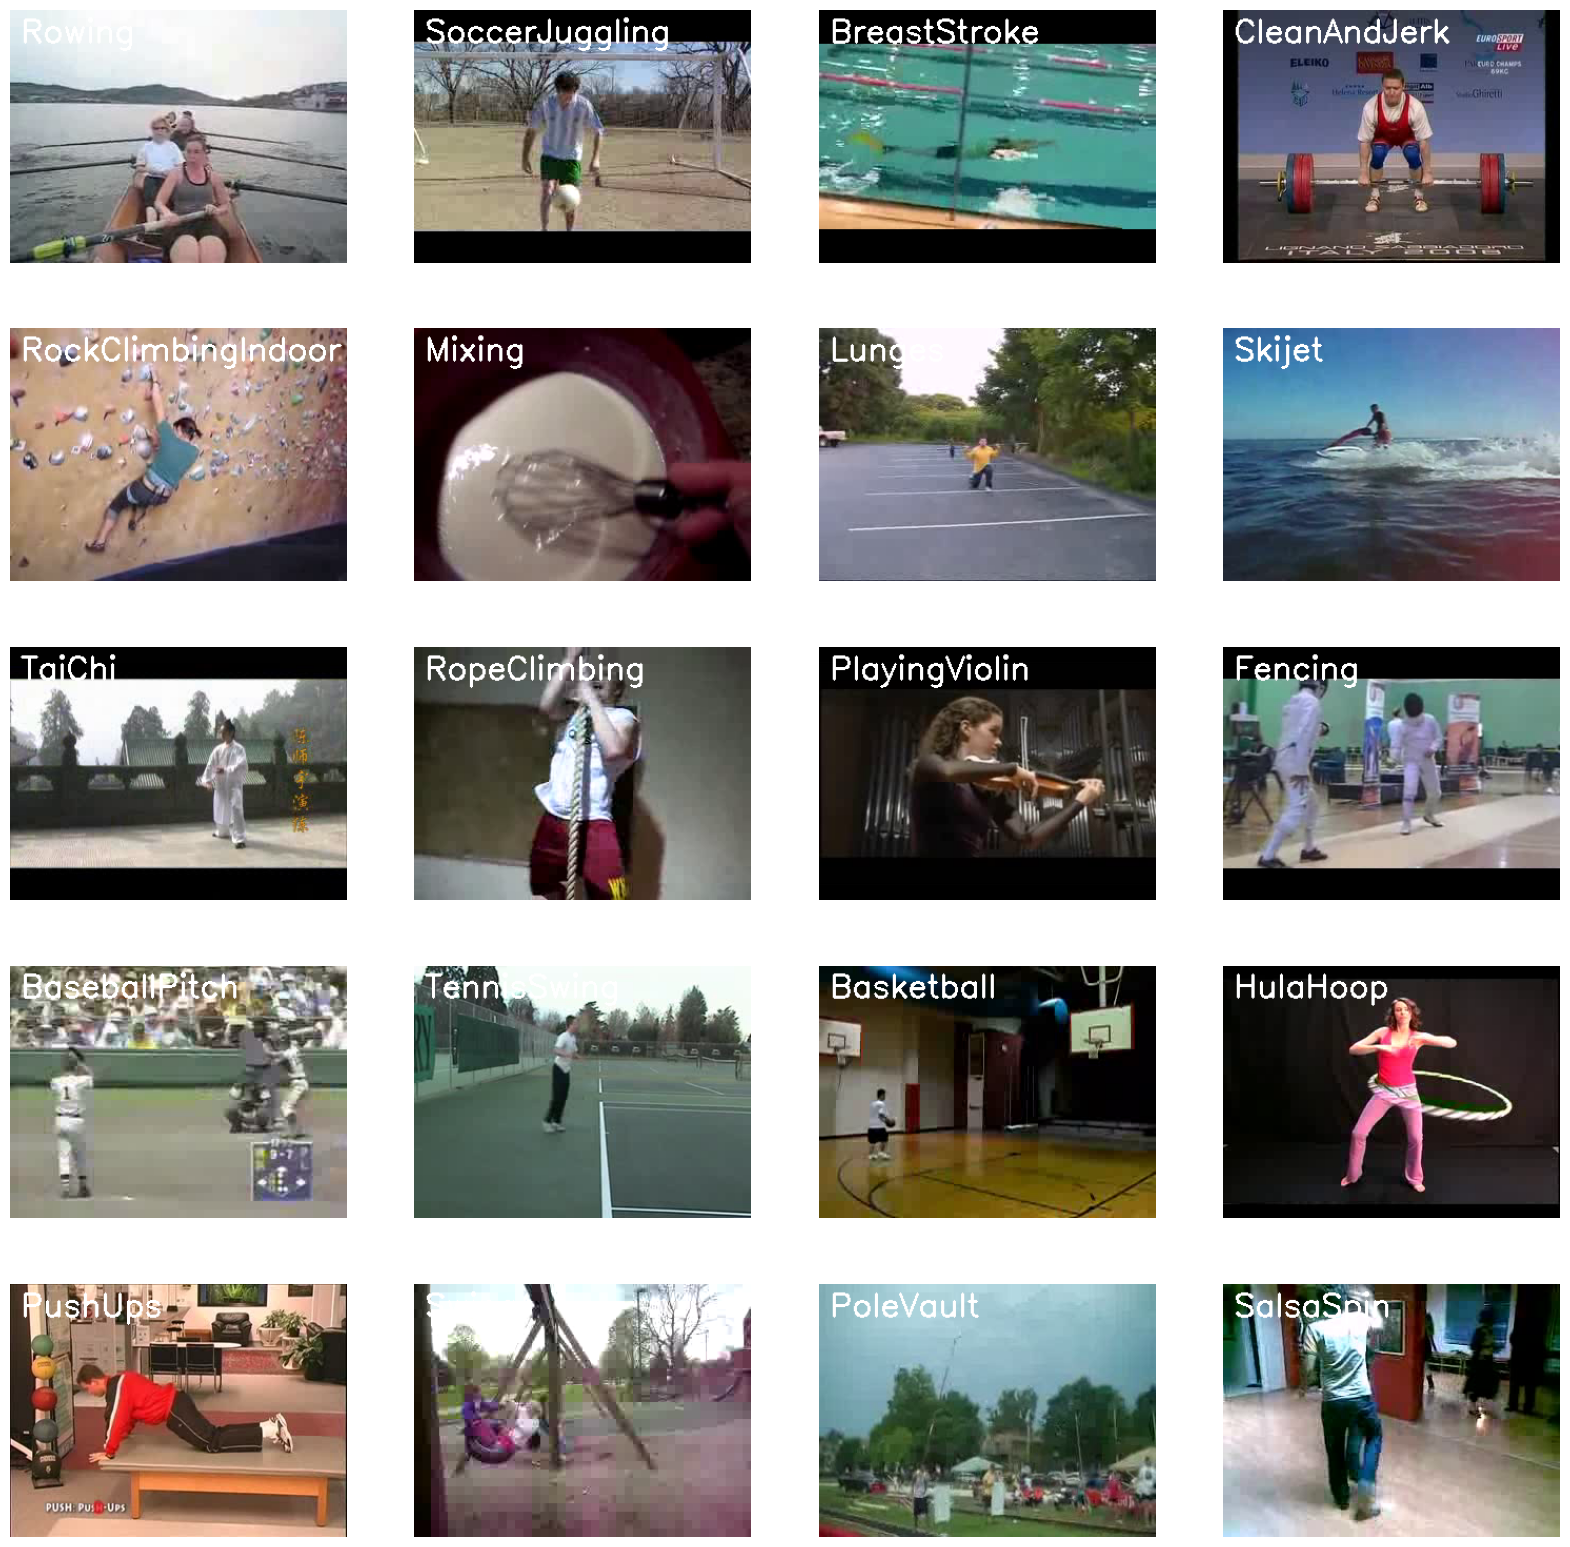

In [ ]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('/content/UCF50_dataset/UCF50')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50_dataset/UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'UCF50_dataset/UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);
    plt.imshow(rgb_frame);
    plt.axis('off')

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224  # Updated from 64, 64 to match Xception input

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "UCF50_dataset/UCF50"

# Specify the list containing the names of the classes used for training.
CLASSES_LIST = ["WalkingWithDog", "TaiChi"]

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi


In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                            one_hot_encoded_labels,
                                                                            test_size = 0.25,
                                                                            shuffle = True,
                                                                            random_state = 27)

In [ ]:
def create_xception_lstm_model():
    '''
    This function will construct the Xception + LSTM model.
    Returns:
        model: It is the constructed Xception + LSTM model.
    '''
    model = Sequential()

    # Xception model for feature extraction from frames
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Create the feature extractor
    feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

    # Add TimeDistributed wrapper to apply Xception on each frame in the sequence
    model.add(TimeDistributed(feature_extractor, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    # Flatten the features extracted by Xception
    model.add(TimeDistributed(Flatten()))

    # Add LSTM to process the sequence of frame features
    model.add(LSTM(128, activation='relu'))

    # Add Dropout to avoid overfitting
    model.add(Dropout(0.2))

    # Output layer for activity classification (softmax for multi-class classification)
    model.add(Dense(len(CLASSES_LIST), activation="softmax"))

    # Summary of the model
    model.summary()

    return model


In [ ]:
# Construct the required convlstm model.
xlstm_model = create_xception_lstm_model()

# Display the success message.
print("Model Created Successfully!")

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 7, 7, 2048) │    20,861,480 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 100352)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │    51,446,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,308,010 (275.83 MB)

 Trainable params: 72,253,482 (275.63 MB)

 Non-trainable params: 54,528 (213.00 KB)

Model Created Successfully!


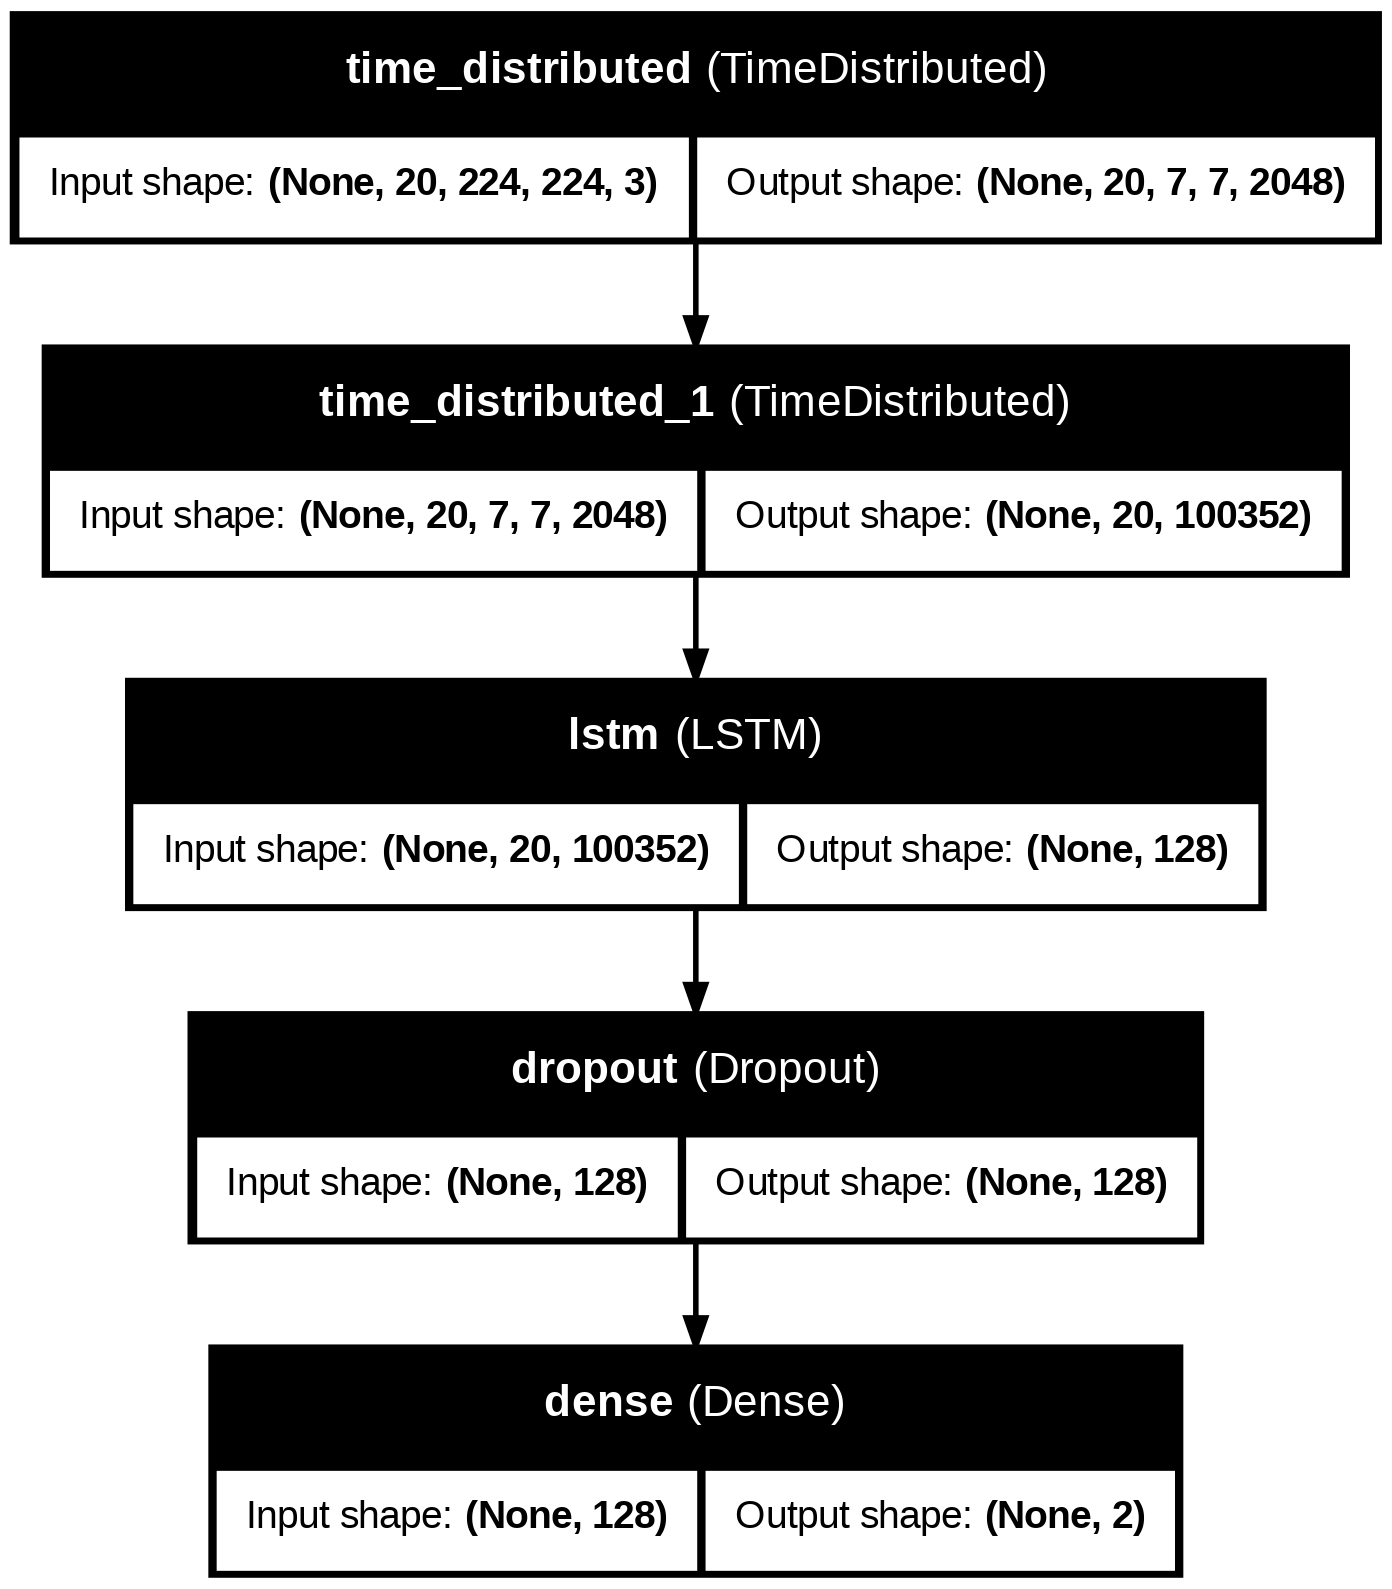

In [ ]:
# Plot the structure of the contructed model.
plot_model(xlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
print("Traiing Model...")

Traiing Model...


In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
xlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = xlstm_model.fit(x = features_train,
                                                     y = labels_train,
                                                     epochs = 10,
                                                     batch_size = 2,
                                                     shuffle = True,
                                                     validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

In [ ]:
# Evaluate the trained model.
model_evaluation_history = xlstm_model.evaluate(features_test, labels_test)

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
     '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''

     # Create a video object which contains useful information about the video.
     video = pafy.new(youtube_video_url)

     # Retrieve the title of the video.
     title = video.title

     # Get the best available quality object for the video.
     video_best = video.getbest()

     # Construct the output file path.
     output_file_path = f'{output_directory}/{title}.mp4'

     # Download the youtube video at the best available quality and store it to the contructed path.
     video_best.download(filepath = output_file_path, quiet = True)

     # Return the video title.
     return title

In [ ]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [ ]:
# Construct the output video path.
output_video_file_path = f'new/Output-SeqLen.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video("/content/Test Video.mp4", output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

In [ ]:
import cv2
import numpy as np
from collections import deque
from moviepy.editor import VideoFileClip

# Define model-related constants
SEQUENCE_LENGTH = 20  # Set this based on your model
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64  # Set this based on your training
CLASSES_LIST = ['Walking', 'Running', 'Jumping']  # Replace with your actual class names

# Load your trained model (assumes it's already loaded globally as convlstm_model)
# convlstm_model = ... (your model loading code here)

def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    Perform action recognition on a video using the LRCN model.

    Args:
    - video_file_path: str, input video path
    - output_file_path: str, where to save output video with predictions
    - SEQUENCE_LENGTH: int, number of frames per prediction sequence
    '''

    # Initialize the VideoCapture object
    video_reader = cv2.VideoCapture(video_file_path)

    # Get video properties
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video_reader.get(cv2.CAP_PROP_FPS)

    # Create VideoWriter object
    video_writer = cv2.VideoWriter(
        output_file_path,
        cv2.VideoWriter_fourcc(*'mp4v'),
        fps,
        (original_video_width, original_video_height)
    )

    # Frame queue and predicted class label
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    predicted_class_name = ''

    while True:
        ok, frame = video_reader.read()

        # Break loop if no frame is returned
        if not ok or frame is None:
            break

        # Resize and normalize frame
        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        normalized_frame = resized_frame / 255.0

        # Append to queue
        frames_queue.append(normalized_frame)

        # Predict action when enough frames are collected
        if len(frames_queue) == SEQUENCE_LENGTH:
            input_batch = np.expand_dims(frames_queue, axis=0)  # Shape: (1, SEQUENCE_LENGTH, H, W, 3)
            predicted_probabilities = convlstm_model.predict(input_batch)[0]
            predicted_label = np.argmax(predicted_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Overlay prediction on original frame
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 255, 0), 2, cv2.LINE_AA)

        # Write frame to output
        video_writer.write(frame)

    # Release resources
    video_reader.release()
    video_writer.release()
    print(f"Prediction complete. Output saved to {output_file_path}")

# ==== Run the prediction ====

# Example usage
input_video_path = "/content/Test Video.mp4"
output_video_path = "new/Output-SeqLen.mp4"

# Make sure output folder exists
import os
os.makedirs(os.path.dirname(output_video_path), exist_ok=True)

# Run prediction
predict_on_video(input_video_path, output_video_path, SEQUENCE_LENGTH)

# Display the output video
VideoFileClip(output_video_path, audio=False, target_resolution=(300, None)).ipython_display()


In [ ]:
!wget https://drive.google.com/file/d/1c7j6_zgCsC1wq1Zxg-gZE_6Zk_Fo-UZj/view?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')